Try and keep it to cpu rather than gpu
1. have a couple options for embedding styles (pass function into another function)
2. use pillow histogram initially

In [34]:
import pynndescent # https://pynndescent.readthedocs.io/en/latest/how_to_use_pynndescent.html#Nearest-neighbors-of-the-training-set
from PIL import Image # Pillow
import os # for getting filenames

import numpy as np

IMAGE_FOLDER = './images'

# 1. Load images 

In [17]:
image_filenames = os.listdir(path=IMAGE_FOLDER)
image_filenames[0:3]

['102654286_3264583356961955_4146541842349978960_n.jpg',
 '80131083_262180578535960_4942330824008077400_n.jpg',
 '73297222_2569101113327948_4326824972505996829_n.jpg']

<class 'PIL.JpegImagePlugin.JpegImageFile'>
[217, 100, 132, 391, 942, 4961, 5471, 17856, 107282, 12908, 24153, 20018, 9394, 9325, 4527, 8380, 5716, 4159, 6068, 4032, 5817, 3597, 2669, 2576, 2506, 2141, 2256, 2315, 2209, 2151, 1934, 1732, 1977, 1960, 2162, 1917, 2019, 1884, 1873, 2140, 1991, 2040, 2085, 2014, 2085, 2189, 2122, 2097, 2124, 2047, 2163, 2181, 2084, 2073, 2049, 2104, 2013, 2176, 2185, 2340, 2222, 2356, 2292, 2524, 2464, 2476, 2616, 2742, 2481, 2556, 2684, 2649, 2680, 2707, 2536, 2625, 2658, 2644, 2635, 2644, 2659, 2637, 2724, 2884, 2805, 2814, 2774, 2996, 2809, 2880, 2757, 2863, 2744, 2741, 2698, 2727, 2670, 2835, 2679, 2716, 2664, 2766, 2699, 2717, 2782, 2862, 2812, 2906, 2828, 2804, 2791, 2788, 2671, 2787, 2663, 2720, 2658, 2759, 2660, 2609, 2656, 2680, 2650, 2820, 2818, 2753, 2861, 2784, 2985, 2963, 3078, 3174, 3467, 3280, 3093, 3295, 3388, 3322, 3150, 3047, 2964, 2971, 3169, 3068, 3027, 3152, 3157, 3410, 2997, 3058, 3021, 3329, 3223, 3281, 3245, 3343, 3636, 3729, 3839, 

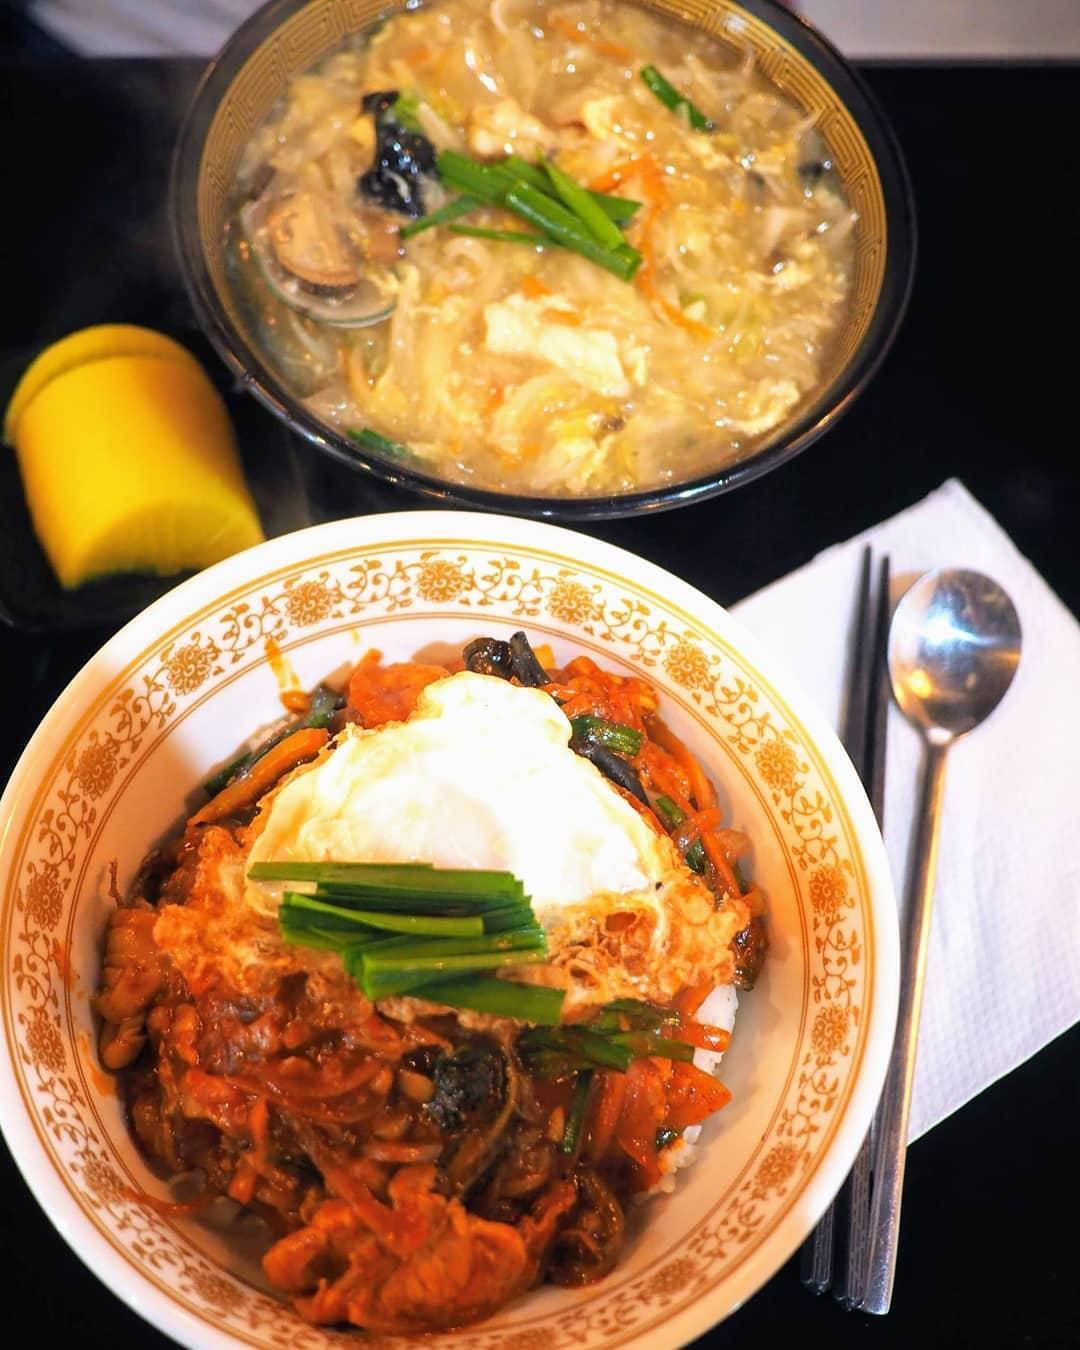

In [ ]:
with Image.open(IMAGE_FOLDER + '/' + image_filenames[0]) as img:
    print(type(image))
    print(img.histogram()) # Colour histogram
    display(img)

# 2. "Embedding"
Make a function that takes in a list of filenames and an embedding function and returns "embedding graph"

Format:
[(filename, embedding),
(filename, embedding),
...]

In [63]:
def get_embedding_graph(image_filenames = [], embedding_function = lambda img : img.histogram()) -> "[embedding_function(img_0),...]":
    """
    Params:
        - image_filenames: list of filenames within IMAGE_FOLDER.
        - embedding_function: a function which takes in <class 'PIL.JpegImagePlugin.JpegImageFile'>
        and returns a 1D array of floats.

    Returns:
        - embedding_graph: list of embedding where the ith row in embedding_graph.
        corresponds to the ith image_filename in image_filenames.
    """
    embedding_graph = []

    #todo Vectorise/do a better way
    for image_filename in image_filenames:
        with Image.open(IMAGE_FOLDER + '/' + image_filename) as img:
            embedding_graph.append(embedding_function(img)) # add the embedding of the image to the given function

    return np.array(embedding_graph)

In [64]:
embedding_graph = get_embedding_graph(image_filenames=image_filenames[0:10])

# 3. Get KNN

In [65]:
def get_knn(embedding_graph, n_neighbours=10) -> ("nearest_neighbours_array", "neighbours_distance_array"):
    """
    Params:
        - embedding_graph: numpy array of embeddings. #? not a great description
        - n_neighbours: number of nearest neighbours returned.

    Returns:
        - nearest_neighbour_array: an array where the ith row corresponds to the n
        nearest neighbours for the ith point.
        - neighbours_distance_array: an array where the ith row corresponds to 
        the distances of the n nearest neighbours from the ith point.
    """

index = pynndescent.NNDescent(embedding_graph, n_neighbors=3)

In [60]:
index.neighbor_graph


(array([[0, 4, 2],
        [1, 9, 8],
        [2, 4, 8],
        [3, 2, 4],
        [4, 2, 7],
        [2, 4, 3],
        [6, 2, 4],
        [7, 1, 8],
        [8, 9, 1],
        [9, 1, 8]], dtype=int32),
 array([[     0.   , 237632.81 , 241855.56 ],
        [     0.   ,  31522.506,  55334.125],
        [     0.   ,  94543.23 , 122505.055],
        [     0.   , 226222.44 , 237416.4  ],
        [     0.   ,  94543.23 , 129761.836],
        [196552.1  , 247929.14 , 288811.2  ],
        [     0.   , 249825.98 , 251727.08 ],
        [     0.   ,  79834.02 ,  82379.99 ],
        [     0.   ,  54329.273,  55334.125],
        [     0.   ,  31522.506,  54329.273]], dtype=float32))